### TODO
1. 模型过拟合，加入batchNormalization和dropout
2. 增加LSTM堆叠，提高模型accuracy
3. 按照LSTM的代码格式，修改两个CNN的格式重新训练，训练完保存模型

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import utils, regularizers
from tensorflow.keras.callbacks import TensorBoard, LearningRateScheduler
from tensorflow.keras import backend as K

from utils.data import load_capg_data, CapgDBName, LoadMode

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
K.set_session(session)  # set this TensorFlow session as the default session for Keras

In [2]:
# set const values
weights_file = './models/capg_lstm_weights.h5'
model_file = './models/capg_lstm_model.h5'
window_len = 50

In [3]:
# load capg dba data
x, y, category = load_capg_data(CapgDBName.dba, LoadMode.sequence)
seg_length = int(x.shape[1] / window_len)

x = x.reshape(x.shape[0]*seg_length, window_len, x.shape[2])
y = y.reshape(y.shape[0], 1) * np.ones((1, seg_length))
y = y.flatten()
y = utils.to_categorical(y - 1, category)

print(x.shape)
print(y.shape)

(28800, 50, 128)
(28800, 8)


In [4]:
model = Sequential()
model.add(LSTM(256, activation='relu', input_shape=(window_len, 128), dropout=0.2,
               activity_regularizer=regularizers.l2(l=0.01), name='lstm_1'))
# model.add(LSTM(256, activation='relu', return_sequences=True, name='lstm_2'))  # returns a sequence of vectors of dimension 32
# model.add(LSTM(256, activation='relu', name='lstm_3'))  # return a single vector of dimension 32
model.add(Dense(8, activation='softmax', name='output'))

if os.path.exists(model_file):
    print('load weights from a trained model')
    model.load_weights(model_file, by_name=True)
else:
    print('train a new model')

W0315 22:33:39.115752 140551768930048 tf_logging.py:161] <tensorflow.python.keras.layers.recurrent.UnifiedLSTM object at 0x7fd3c47c1ef0>: Note that this layer is not optimized for performance. Please use tf.keras.layers.CuDNNLSTM for better performance on GPU.
W0315 22:33:39.370231 140551768930048 deprecation.py:506] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/keras/backend.py:4081: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


train a new model


In [5]:
sgd = SGD(clipnorm=1, clipvalue=0.5, momentum=0.9)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (UnifiedLSTM)         (None, 256)               394240    
_________________________________________________________________
output (Dense)               (None, 8)                 2056      
Total params: 396,296
Trainable params: 396,296
Non-trainable params: 0
_________________________________________________________________


In [6]:
# tb_callback = TensorBoard(log_dir='./logs/lstm/',
#                           histogram_freq=1,
#                           batch_size=32,
#                           write_grads=True,
#                           update_freq='batch')

In [7]:
def learning_rate_tuner(epoch):
    lr = 0.1
    if 20 <= epoch < 40:
        lr = 0.01
    elif epoch >= 40:
        lr = 0.001
    return lr

lr_scheduler = LearningRateScheduler(learning_rate_tuner)

In [8]:
history = model.fit(x, y, batch_size=128, epochs=60, validation_split=0.1,
                    callbacks=[lr_scheduler])

Train on 25920 samples, validate on 2880 samples
Epoch 1/60
25920/25920 [==============================] - 20s 759us/sample - loss: 2.0673 - accuracy: 0.1369 - val_loss: 2.0715 - val_accuracy: 0.1361
Epoch 2/60
25920/25920 [==============================] - 19s 716us/sample - loss: 2.0502 - accuracy: 0.1598 - val_loss: 2.0422 - val_accuracy: 0.1545
Epoch 3/60
25920/25920 [==============================] - 18s 712us/sample - loss: 2.0540 - accuracy: 0.1640 - val_loss: 2.0436 - val_accuracy: 0.1663
Epoch 4/60
25920/25920 [==============================] - 18s 708us/sample - loss: 2.0028 - accuracy: 0.1898 - val_loss: 1.8969 - val_accuracy: 0.2385
Epoch 5/60
25920/25920 [==============================] - 19s 721us/sample - loss: 1.9357 - accuracy: 0.2062 - val_loss: 1.9297 - val_accuracy: 0.1983
Epoch 6/60
25920/25920 [==============================] - 19s 716us/sample - loss: 1.8765 - accuracy: 0.2270 - val_loss: 1.8162 - val_accuracy: 0.2799
Epoch 7/60
25920/25920 [=====================

In [9]:
model.save_weights(weights_file)
model.save(model_file)
print(history.history.keys())

dict_keys(['val_loss', 'loss', 'val_accuracy', 'accuracy', 'lr'])


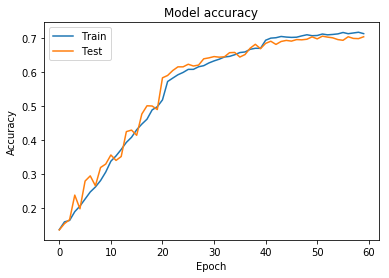

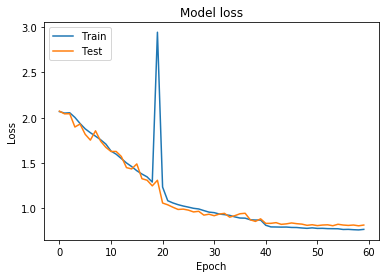

In [10]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('./figures/lstm_acc.png')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('./figures/lstm_loss.png')
plt.show()